## Assignment S8 :

* Change the dataset to CIFAR10
* Make this network:
C1 C2 c3 P1 C3 C4 C5 c6 P2 C7 C8 C9 GAP C10
* Keep the parameter count less than 50000
* Try and add one layer to another
* Max Epochs is 20
* You are making 3 versions of the above code (in each case achieve above 70% accuracy):
  * Network with Group Normalization
  * Network with Layer Normalization
  * Network with Batch Normalization
* Print 10 Misclassified image.




In [1]:
%load_ext autoreload

In [2]:

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries

In [3]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from utils import test, train, plot_curves,get_incorrect_predictions
from visualize import print_samples,print_class_scale,plot_confusion_matrix,plot_incorrect_predictions
from model import Net
from torchsummary import summary

from torch.optim.lr_scheduler import StepLR

import warnings
warnings.filterwarnings('ignore')

Defining data tranformations

In [4]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation((-10., 10.), fill=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


Downloading MNIST dataset and splitting to train and test set

In [5]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 49238484.39it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [7]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
EPOCHS = 20

Creating Data Loaders from train data and test data

In [8]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

kwargs = {'shuffle' : True,'batch_size' : BATCHSIZE,'num_workers': 4, 'pin_memory': True} if cuda else {'shuffle' : True,'batch_size' : BATCHSIZE_2}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs) # creating train data loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs) # creating test dataloader

CUDA Available True


In [9]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']


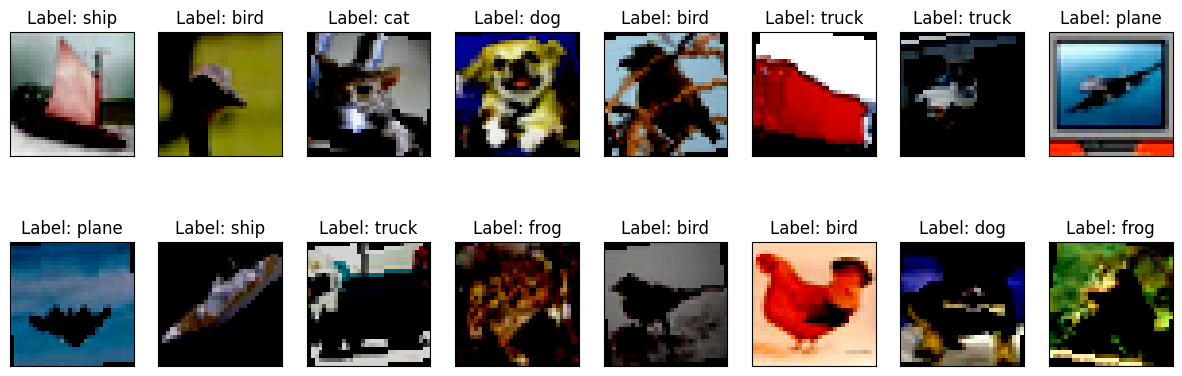

In [10]:
print_samples(train_loader,classes)

Transferring model to GPU and printing model summary

In [11]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = Net(norm="GN").to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             270
         GroupNorm-2           [-1, 10, 32, 32]              20
         Dropout2d-3           [-1, 10, 32, 32]               0
            Conv2d-4           [-1, 10, 32, 32]             900
         GroupNorm-5           [-1, 10, 32, 32]              20
         Dropout2d-6           [-1, 10, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             160
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 24, 16, 16]           3,456
        GroupNorm-10           [-1, 24, 16, 16]              48
        Dropout2d-11           [-1, 24, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           3,456
        GroupNorm-13           [-1, 16, 16, 16]              32
        Dropout2d-14           [-1, 16,

In [12]:
model =  Net(norm='GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)

EPOCH: 0


Train: Loss=1.5922 Batch_id=390 Accuracy=34.66: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]


Test set: Average loss: 1.4913, Accuracy: 4591/10000 (45.91%)

EPOCH: 1


Train: Loss=1.1329 Batch_id=390 Accuracy=49.07: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Test set: Average loss: 1.2960, Accuracy: 5324/10000 (53.24%)

EPOCH: 2


Train: Loss=1.0465 Batch_id=390 Accuracy=55.16: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]


Test set: Average loss: 1.1042, Accuracy: 6013/10000 (60.13%)

EPOCH: 3


Train: Loss=1.0489 Batch_id=390 Accuracy=59.59: 100%|██████████| 391/391 [00:46<00:00,  8.32it/s]


Test set: Average loss: 1.0386, Accuracy: 6243/10000 (62.43%)

EPOCH: 4


Train: Loss=0.9742 Batch_id=390 Accuracy=62.64: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]


Test set: Average loss: 1.0227, Accuracy: 6339/10000 (63.39%)

EPOCH: 5


Train: Loss=1.0507 Batch_id=390 Accuracy=64.59: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


Test set: Average loss: 1.0155, Accuracy: 6482/10000 (64.82%)

EPOCH: 6


Train: Loss=1.0273 Batch_id=390 Accuracy=66.63: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]


Test set: Average loss: 0.8644, Accuracy: 6936/10000 (69.36%)

EPOCH: 7


Train: Loss=0.7461 Batch_id=390 Accuracy=67.87: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]


Test set: Average loss: 0.8534, Accuracy: 6998/10000 (69.98%)

EPOCH: 8


Train: Loss=1.0384 Batch_id=390 Accuracy=69.28: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]


Test set: Average loss: 0.7973, Accuracy: 7252/10000 (72.52%)

EPOCH: 9


Train: Loss=0.6777 Batch_id=390 Accuracy=70.37: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Test set: Average loss: 0.7771, Accuracy: 7294/10000 (72.94%)

EPOCH: 10


Train: Loss=0.9141 Batch_id=390 Accuracy=71.00: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]


Test set: Average loss: 0.7553, Accuracy: 7368/10000 (73.68%)

EPOCH: 11


Train: Loss=0.8573 Batch_id=390 Accuracy=71.64: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]


Test set: Average loss: 0.7331, Accuracy: 7500/10000 (75.00%)

EPOCH: 12


Train: Loss=0.8186 Batch_id=390 Accuracy=72.24: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]


Test set: Average loss: 0.7557, Accuracy: 7369/10000 (73.69%)

EPOCH: 13


Train: Loss=0.9054 Batch_id=390 Accuracy=73.39: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]


Test set: Average loss: 0.7565, Accuracy: 7420/10000 (74.20%)

EPOCH: 14


Train: Loss=0.7255 Batch_id=390 Accuracy=73.53: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]


Test set: Average loss: 0.7197, Accuracy: 7508/10000 (75.08%)

EPOCH: 15


Train: Loss=0.9838 Batch_id=390 Accuracy=74.05: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


Test set: Average loss: 0.6979, Accuracy: 7620/10000 (76.20%)

EPOCH: 16


Train: Loss=0.8982 Batch_id=390 Accuracy=74.61: 100%|██████████| 391/391 [00:48<00:00,  8.02it/s]


Test set: Average loss: 0.6783, Accuracy: 7641/10000 (76.41%)

EPOCH: 17


Train: Loss=0.5747 Batch_id=390 Accuracy=74.86: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]


Test set: Average loss: 0.6768, Accuracy: 7668/10000 (76.68%)

EPOCH: 18


Train: Loss=0.5706 Batch_id=390 Accuracy=75.48: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]


Test set: Average loss: 0.6871, Accuracy: 7645/10000 (76.45%)

EPOCH: 19


Train: Loss=0.6210 Batch_id=390 Accuracy=75.42: 100%|██████████| 391/391 [00:48<00:00,  7.98it/s]


Test set: Average loss: 0.6473, Accuracy: 7753/10000 (77.53%)



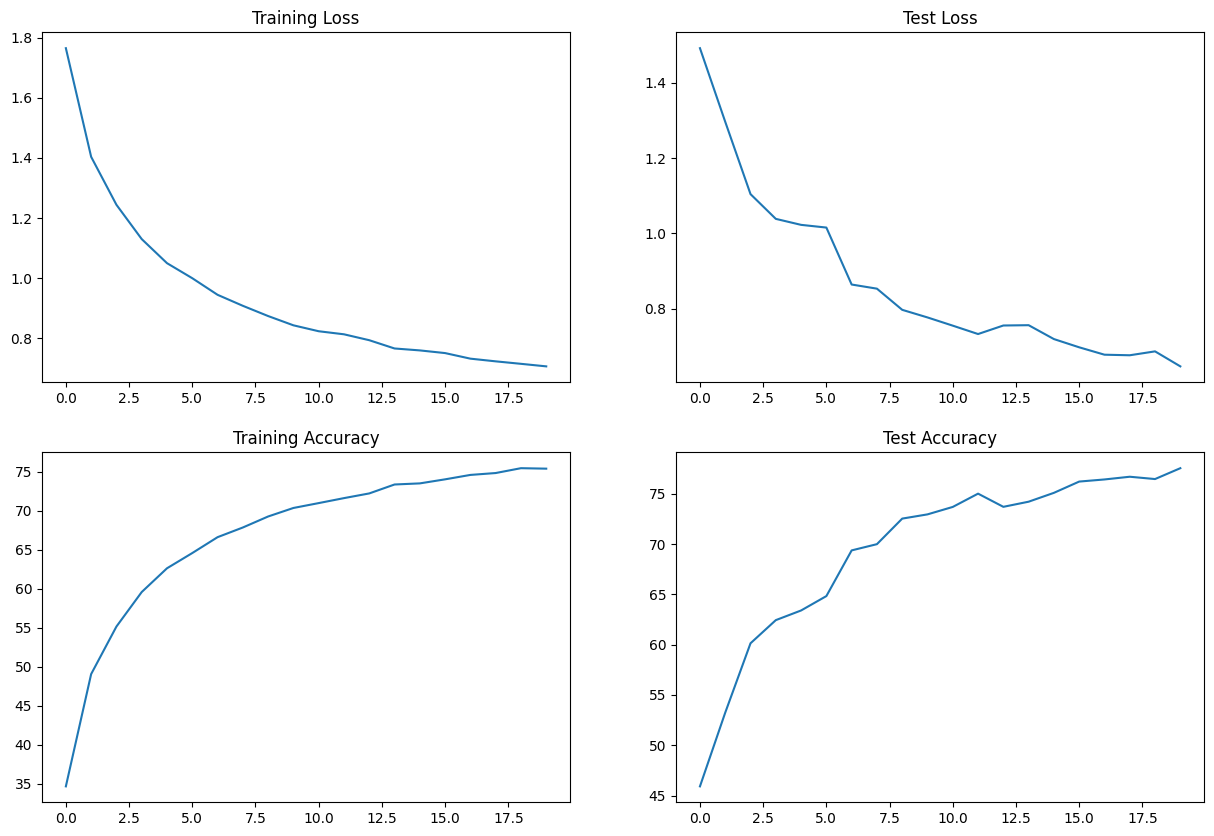

In [13]:
plot_curves()

In [14]:
wrong_prediction_list = get_incorrect_predictions(model,test_loader,device)

Total Incorrect Predictions 2247


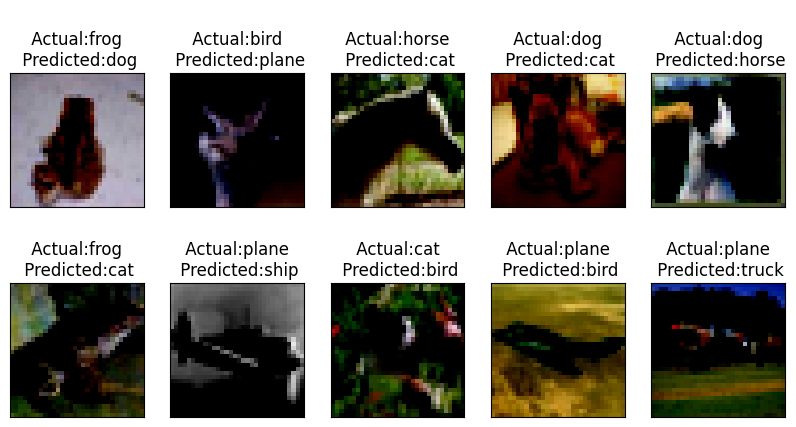

In [15]:
plot_incorrect_predictions(wrong_prediction_list,classes)

## Confusion Matrix

Confusion matrix, without normalization


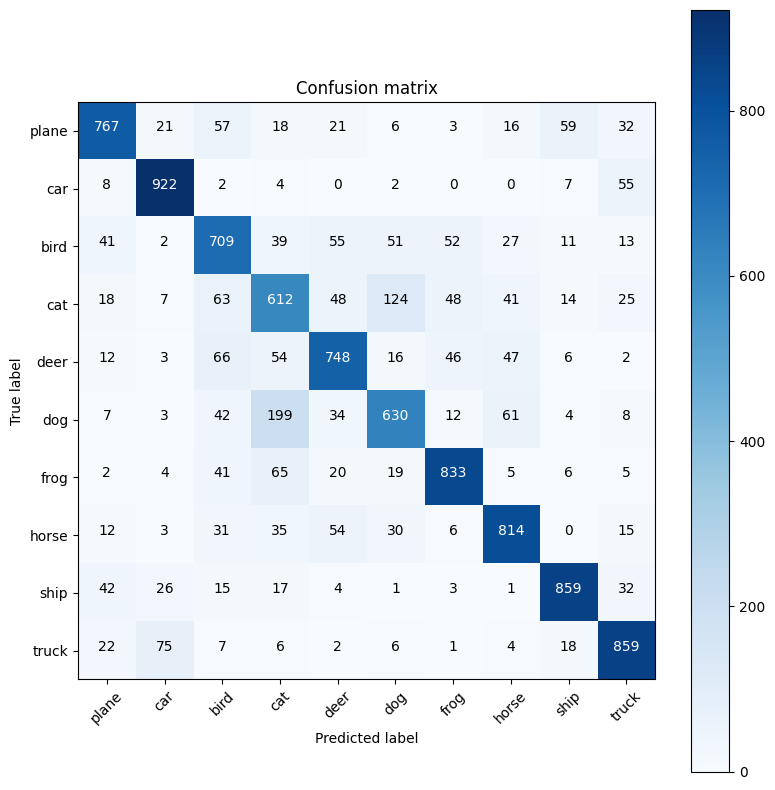

In [16]:
from utils import get_all_predictions, get_incorrect_predictions, prepare_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, classes)
plot_confusion_matrix(confusion_matrix, classes, False)

## Save Model

In [17]:
torch.save(model.state_dict(), 'model_GN.pth')

In [ ]:
# Load Model
#model = Net(norm="BN").to(device)
#model.load_state_dict(torch.load('model_bn.pth'))

<All keys matched successfully>